In [0]:
%matplotlib inline
import torch
from torch import nn,optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

**Gathering and Loading Data**

In [0]:
# from google.colab import drive
# drive.mount('/gdrive')
# !mkdir /data
# !cp "/gdrive/My Drive/dogs-vs-cats.zip" /data
# !unzip /data/dogs-vs-cats.zip -d /data
# !unzip /data/train.zip -d /data
# !unzip /data/test1.zip -d /data
# !mkdir  /data/train/cat
# !mkdir /data/train/dog
# !mv /data/train/*cat* /data/train/cat
# !mv /data/train/*dog* /data/train/dog
# !mkdir /data/test1/test
# !mv /data/test1/* /data/test1/test
# !mkdir /data/test1/test
# !mv /data/test1/* /data/test1/test
# ! mkdir -p /data/test/cat
# !mkdir -p /data/test/dog
# ! mv `ls -d /data/train/cat/* | head -200` /data/test/cat
# ! mv `ls -d /data/train/dog/* | head -200` /data/test/dog

In [0]:
transform=transforms.Compose([transforms.Resize(224),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
traindata=datasets.ImageFolder('/data/train',transform=transform)
trainloader=torch.utils.data.DataLoader(traindata,batch_size=32,shuffle=True)

In [0]:
testdata=datasets.ImageFolder('/data/test',transform=transform)
testloader=torch.utils.data.DataLoader(testdata,batch_size=32,shuffle=True)

**Explore data**

In [0]:
images,labels=next(iter(trainloader))
images_test,labels_test=next(iter(testloader))

In [22]:
images.shape

torch.Size([32, 3, 224, 224])

In [23]:
labels_test

tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


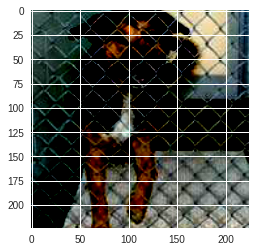

In [25]:
plt.imshow(np.transpose(images,axes=[0,2,3,1])[0])

**CNN Model**

In [0]:
class CNN_Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        self.pool=nn.MaxPool2d(2,stride=2)
        
        self.fc1=nn.Linear(64*28*28,500)
        self.fc2=nn.Linear(500,250)
        self.fc3=nn.Linear(250,100)
        self.output=nn.Linear(100,2)
        self.relu=nn.ReLU()
        self.log_softmax=nn.LogSoftmax(dim=1)
        
        self.dropout=nn.Dropout(0.2)
        
    def forward(self,x):
        x=self.relu(self.conv1(x))
        x=self.pool(x)
        
        x=self.relu(self.conv2(x))
        x=self.pool(x)
        
        x=self.relu(self.conv3(x))
        x=self.pool(x)
        
        x=x.view(x.shape[0],-1)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.dropout(F.relu(self.fc3(x)))
        
        x=self.log_softmax(self.output(x))
        
        return x
         

**Model Objects**

In [0]:
model=CNN_Network() 
criterion=nn.NLLLoss()
# criterion.cuda()
optimizer=optim.Adam(model.parameters(),lr=0.003)
model=model.cuda()

**Running the Model**

In [0]:
epoch=10
for e in range(epoch):
    c=0
    running_loss=0
    train_losses=[]
    test_losses=[]
    for images,labels in trainloader:
      
      #Forward propagation
      images=images.cuda()
      logits=model.forward(images)
        
       #backward propagation
        
      labels=labels.cuda()
      optimizer.zero_grad()
      loss=criterion(logits,labels)
      loss.backward()
        
      optimizer.step()
        
      running_loss+=loss.item()
    else:
      test_loss=0
      accuracy=0
      with torch.no_grad():
        model.eval()
        for images,labels in testloader:
          images=images.cuda()
          test_logits=model.forward(images)
          
          labels=labels.cuda()
          test_loss=criterion(test_logits,labels)
          
          ps=torch.exp(test_loss)
          top_p,top_class=test_logits.topk(1,dim=1)
          equals=top_class==labels.view(top_class.shape)
          accuracy+=torch.mean(equals.type(torch.FloatTensor))
      model.train()
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(testloader))
      print('Epoch: {}/{}'.format(e+1,epoch),
             'Train loss: {:.3f}'.format(running_loss/len(trainloader)),
             'Test loss: {:.3f}'.format(test_loss/len(testloader)),
             'Test Accuracy: {:.3f}%'.format((accuracy/len(testloader))*100))

Epoch: 1/10 Train loss: 0.693 Test loss: 0.053 Test Accuracy: 50.240%
